In [21]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from matplotlib.animation import FuncAnimation
import sympy as sp
from IPython.display import HTML


In [38]:
# Pendulum parameters (lengths and masses)
l1, l2, l3 = [1.0, 1.0, 1.0]  # Lengths of the pendulum arms
m1, m2, m3 = [1.0, 1.0, 1.0]   # Masses of the pendulum bobs
g = 9.81  # gravitational acceleration
L = l1 + l2 + l3

# Initial conditions
y0 = [np.random.uniform(0, 2 * np.pi), 0, np.random.uniform(0, 2 * np.pi), 0, np.random.uniform(0, 2 * np.pi), 0]

# Time span
t_end = 100
frames = 500
t_span = [0, t_end]
t_eval = np.linspace(t_span[0], t_span[1], frames)
y0

[3.101644465416134, 0, 2.852888590122805, 0, 1.6128540921639174, 0]

In [39]:
# Define symbols for angles, angular velocities, and angular accelerations
theta1, theta2, theta3 = sp.symbols('theta1 theta2 theta3', real=True, check=False)
dot_theta1, dot_theta2, dot_theta3 = sp.symbols('dot_theta1 dot_theta2 dot_theta3', real=True, check=False)
ddot_theta1, ddot_theta2, ddot_theta3 = sp.symbols('ddot_theta1 ddot_theta2 ddot_theta3', real=True, check=False)

In [40]:
# Equations of motion
eq1 = (g*l1*(m1*sp.sin(theta1) + m2*sp.sin(theta1) + m3*sp.sin(theta1)) + m2*l1*l2*sp.sin(theta1 - theta2)*dot_theta1*dot_theta2
        + m3*l1*l3*sp.sin(theta1-theta3)*dot_theta1*dot_theta3 + m3*l1*l2*sp.sin(theta1-theta2)*dot_theta1*dot_theta2 + l1*l1*ddot_theta1*(m1+m2+m3)
        + m2*l1*l2*(sp.sin(theta2-theta1)*(dot_theta1-dot_theta2)*dot_theta2 + sp.cos(theta1-theta2)*ddot_theta2) 
        + m3*l1*l2*(sp.sin(theta2-theta1)*(dot_theta1-dot_theta2)*dot_theta2 + sp.cos(theta1-theta2)*ddot_theta2)
        + m3*l1*l3*(sp.sin(theta3-theta1)*(dot_theta1-dot_theta3)*dot_theta3 + sp.cos(theta1-theta3)*ddot_theta3))

eq2 = (g*l2*(m2*sp.sin(theta2) + m3*sp.sin(theta2)) + dot_theta1*dot_theta2*l1*l2*sp.sin(theta2-theta1)*(m2+m3)
        + m3*l2*l3*sp.sin(theta2-theta3)*dot_theta2*dot_theta3 + l2*l2*ddot_theta2*(m2+m3)
        + (m2+m3)*l1*l2*(sp.sin(theta2-theta1)*(dot_theta1-dot_theta2)*dot_theta1 + sp.cos(theta2-theta1)*ddot_theta1)
        + m3*l2*l3*(sp.sin(theta3-theta2)*(dot_theta2-dot_theta3)*dot_theta3 + sp.cos(theta2-theta3)*ddot_theta3))

eq3 = (m3*g*l3*sp.sin(theta3) - m3*l2*l3*sp.sin(theta2-theta3)*dot_theta2*dot_theta3 - m3*l1*l3*sp.sin(theta1-theta3)*dot_theta1*dot_theta3
        + m3*l1*l3*(sp.sin(theta3-theta1)*(dot_theta1-dot_theta3)*dot_theta1 + sp.cos(theta1-theta3)*ddot_theta1)
        + m3*l2*l3*(sp.sin(theta3-theta2)*(dot_theta2-dot_theta3)*dot_theta2 + sp.cos(theta2-theta3)*ddot_theta2) + m3*l3*l3*ddot_theta3)

In [41]:
solutions = sp.solve([eq1, eq2, eq3], [ddot_theta1, ddot_theta2, ddot_theta3])
solutions

{ddot_theta1: 400.0*dot_theta1**2*sin(theta1 - theta2)*cos(theta1 - theta2)/(400.0*cos(theta1 - theta2)**2 - 400.0*cos(theta1 - theta2)*cos(theta1 - theta3)*cos(theta2 - theta3) + 200.0*cos(theta1 - theta3)**2 + 300.0*cos(theta2 - theta3)**2 - 600.0) - 200.0*dot_theta1**2*sin(theta1 - theta2)*cos(theta1 - theta3)*cos(theta2 - theta3)/(400.0*cos(theta1 - theta2)**2 - 400.0*cos(theta1 - theta2)*cos(theta1 - theta3)*cos(theta2 - theta3) + 200.0*cos(theta1 - theta3)**2 + 300.0*cos(theta2 - theta3)**2 - 600.0) - 200.0*dot_theta1**2*sin(theta1 - theta3)*cos(theta1 - theta2)*cos(theta2 - theta3)/(400.0*cos(theta1 - theta2)**2 - 400.0*cos(theta1 - theta2)*cos(theta1 - theta3)*cos(theta2 - theta3) + 200.0*cos(theta1 - theta3)**2 + 300.0*cos(theta2 - theta3)**2 - 600.0) + 200.0*dot_theta1**2*sin(theta1 - theta3)*cos(theta1 - theta3)/(400.0*cos(theta1 - theta2)**2 - 400.0*cos(theta1 - theta2)*cos(theta1 - theta3)*cos(theta2 - theta3) + 200.0*cos(theta1 - theta3)**2 + 300.0*cos(theta2 - theta3)**2

In [42]:
# Convert the solutions to a numerical function
# Define a function for the first-order derivatives of the state variables
def triple_pendulum(t, y):
    print(f'{y}')
    # Unpack the state variables
    t1, dt1, t2, dt2, t3, dt3 = y

    # Convert the symbolic solutions to numerical functions
    ddot_theta1_num = sp.lambdify((theta1, dot_theta1, theta2, dot_theta2, theta3, dot_theta3), solutions[ddot_theta1])
    ddot_theta2_num = sp.lambdify((theta1, dot_theta1, theta2, dot_theta2, theta3, dot_theta3), solutions[ddot_theta2])
    ddot_theta3_num = sp.lambdify((theta1, dot_theta1, theta2, dot_theta2, theta3, dot_theta3), solutions[ddot_theta3])

    # Compute the accelerations
    ddt1 = ddot_theta1_num(t1, dt1, t2, dt2, t3, dt3)
    ddt2 = ddot_theta2_num(t1, dt1, t2, dt2, t3, dt3)
    ddt3 = ddot_theta3_num(t1, dt1, t2, dt2, t3, dt3)

    # Return the first-order derivatives
    return [dt1, ddt1, dt2, ddt2, dt3, ddt3]

In [43]:
# Calculate pendulum positions
def get_positions(y):
    x1 = l1 * np.sin(y[0])
    x2 = x1 + l2 * np.sin(y[2])
    x3 = x2 + l3 * np.sin(y[4])

    y1 = -l1 * np.cos(y[0])
    y2 = y1 - l2 * np.cos(y[2])
    y3 = y2 - l3 * np.cos(y[4])
    return x1, y1, x2, y2, x3, y3

# Using solve_ivp

In [44]:
# Solve the system
solution = solve_ivp(triple_pendulum, t_span, y0, t_eval=t_eval)
solution

[3.10164447 0.         2.85288859 0.         1.61285409 0.        ]
[ 3.10164447e+00  3.45298932e-06  2.85288859e+00 -5.75499465e-06
  1.61285409e+00 -1.59592761e-05]
[ 3.10164447e+00  6.90597864e-05  2.85288859e+00 -1.15099893e-04
  1.61285409e+00 -3.19185523e-04]
[ 3.10164447e+00  1.03589679e-04  2.85288859e+00 -1.72649841e-04
  1.61285408e+00 -4.78778282e-04]
[ 3.10164449e+00  2.76239188e-04  2.85288856e+00 -4.60399706e-04
  1.61285400e+00 -1.27674204e-03]
[ 3.10164449e+00  3.06932482e-04  2.85288855e+00 -5.11555344e-04
  1.61285398e+00 -1.41860223e-03]
[ 3.10164450e+00  3.45299036e-04  2.85288854e+00 -5.75499769e-04
  1.61285395e+00 -1.59592750e-03]
[ 3.10164450e+00  3.45298970e-04  2.85288854e+00 -5.75499635e-04
  1.61285395e+00 -1.59592754e-03]
[ 3.10164462e+00  1.03589707e-03  2.85288833e+00 -1.72649958e-03
  1.61285338e+00 -4.78778230e-03]
[ 3.10164496e+00  1.38119681e-03  2.85288777e+00 -2.30200591e-03
  1.61285181e+00 -6.38370628e-03]
[ 3.10164697  0.00310774  2.85288442 -0.0

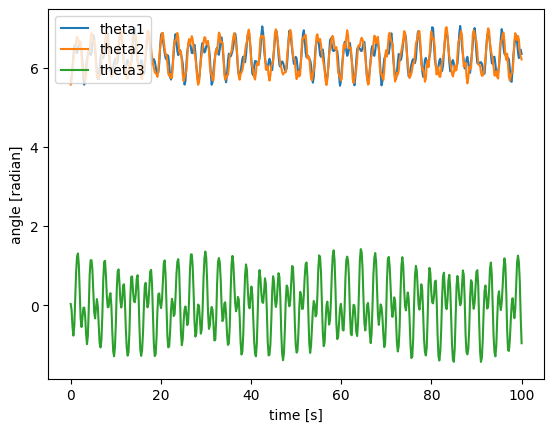

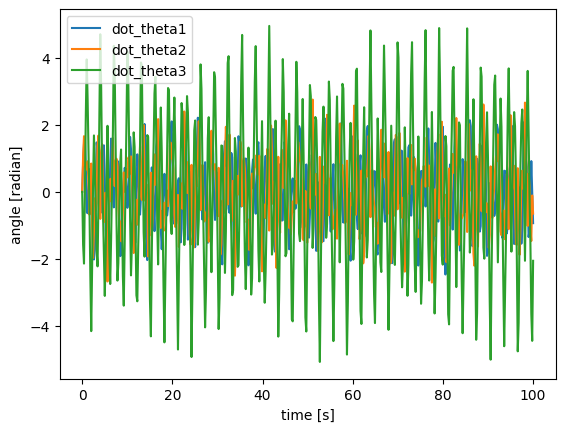

In [ ]:
# Plotting
plt.plot(solution.t, solution.y[0], label='theta1')
plt.plot(solution.t, solution.y[2], label='theta2')
plt.plot(solution.t, solution.y[4], label='theta3')
plt.xlabel('time [s]')
plt.ylabel('angle [radian]')
plt.legend(loc="upper left")
plt.savefig(f'theta_big_{t_end}.png')
plt.show()

plt.plot(solution.t, solution.y[1], label='dot_theta1')
plt.plot(solution.t, solution.y[3], label='dot_theta2')
plt.plot(solution.t, solution.y[5], label='dot_theta3')
plt.xlabel('time [s]')
plt.ylabel('angle [radian]')
plt.legend(loc="upper left")
plt.savefig(f'dot_theta_big_{t_end}.png')
plt.show()

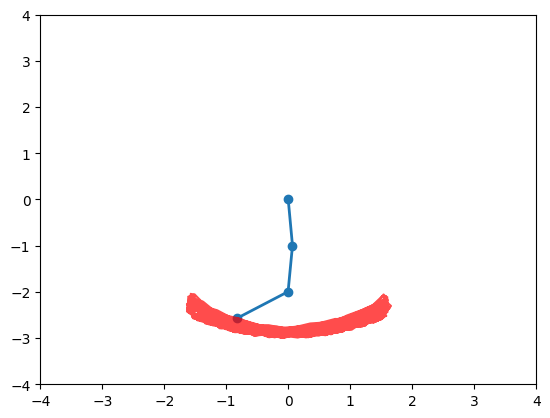

In [ ]:
# Set up the figure and axis
fig, ax = plt.subplots()
ax.set_xlim(-L-1, L+1)
ax.set_ylim(-L-1, L+1)
line, = ax.plot([], [], 'o-', lw=2)
trajectory_line, = ax.plot([], [], 'r-', alpha=0.7)  # Red line for trajectory with 70% transparency

# Variables to store the history of x3, y3
x3_history = []
y3_history = []

# Initialization function
def init():
    line.set_data([], [])
    trajectory_line.set_data([], [])
    return line, trajectory_line

# Animation function
def animate(i):
    x1, y1, x2, y2, x3, y3 = get_positions(solution.y[:, i])
    line.set_data([0, x1, x2, x3], [0, y1, y2, y3])

    # Update the trajectory history
    x3_history.append(x3)
    y3_history.append(y3)
    trajectory_line.set_data(x3_history, y3_history)

    return line, trajectory_line

# Create animation
ani = FuncAnimation(fig, animate, frames=len(solution.t), init_func=init, blit=True, interval=t_end*1000/frames)

# Convert the animation to HTML5 video format
video = ani.to_html5_video()

# Display the animation
HTML(video)

In [ ]:
# save .csv file [t_eval, theta1, dot_theta1, theta2, dot_theta2, theta3, dot_theta3]
np.savetxt(f'result_big_{t_end}.csv', np.concatenate((np.reshape(solution.t, (-1, 1)), np.transpose(solution.y)), axis=1), delimiter=",")